In [1]:
import sys; sys.path.append('..')
import numpy as np
from math import pi, sqrt
import pyzx as zx
%config InlineBackend.figure_format = 'svg'

In [2]:
def Z_to_tensor(arity, phase):
    m = np.zeros([2]*arity, dtype = complex)
    m[(0,)*arity] = 1
    m[(1,)*arity] = np.exp(1j*phase)
    return m

def X_to_tensor(arity, phase):
    m = np.ones(2**arity, dtype = complex)
    for i in range(2**arity):
        if bin(i).count("1")%2 == 0: 
            m[i] += np.exp(1j*phase)
        else:
            m[i] -= np.exp(1j*phase)
    return np.power(np.sqrt(0.5),arity)*m.reshape([2]*arity)

had = 1/sqrt(2)*np.mat([[1,1],[1,-1]])

In [3]:
def pop_and_shift(verts, indices):
    res = []
    for v in verts:
        res.append(indices[v].pop())
    for i in sorted(res,reverse=True):
        for w,l in indices.items():
            l2 = []
            for j in l:
                if j>i: l2.append(j-1)
                else: l2.append(j)
            indices[w] = l2
    return res

def tensorfy(g):
    rows = g.rows()
    phases = g.phases()
    types = g.types()
    depth = g.depth()
    verts_row = {}
    for v in g.vertices():
        r = rows[v]
        if r in verts_row: verts_row[r].append(v)
        else: verts_row[r] = [v]
    
    id2 = np.identity(2)
    tensor = np.identity(2)
    qubits = g.qubit_count()
    for i in range(qubits-1): tensor = np.tensordot(tensor,id2,axes=0)
    inputs = sorted(g.inputs,key=g.qubit)
    indices = {}
    for i in inputs:
        indices[i] = [qubits + g.qubit(i)]
    
    for r in sorted(verts_row.keys()):
        if r == 0: continue #inputs already taken care of
        for v in sorted(verts_row[r]):
            neigh = list(g.neighbours(v))
            d = len(neigh)
            if v in g.outputs: 
                #print("output")
                if d != 1: raise ValueError("Weird output")
                d += 1
                t = id2
            else:
                phase = pi*phases[v]
                t = Z_to_tensor(d,phase) if types[v] == 1 else X_to_tensor(d,phase)
            nn = list(filter(lambda n: rows[n]<r or (rows[n]==r and n<v), neigh))
            ety = {n:g.edge_type(g.edge(v,n)) for n in nn}
            nn.sort(key=lambda n: ety[n])
            for n in nn:
                if ety[n] == 2: #Hadamard edge
                    t = np.tensordot(t,had,(0,0)) # Hadamard edges are moved to the last index of t
            #print(neigh, nn)
            contr = pop_and_shift(nn,indices) #the last indices in contr correspond to hadamard contractions
            #print(contr)
            tensor = np.tensordot(tensor,t,axes=(contr,list(range(len(t.shape)-len(contr),len(t.shape)))))
            indices[v] = list(range(len(tensor.shape)-d+len(contr), len(tensor.shape)))
            #print(indices)
            #print(tensor)
    
    perm = list(range(qubits))
    for o in sorted(g.outputs,key=g.qubit):
        if len(indices[o]) != 1: raise ValueError("Weird output")
        perm.append(indices[o][0])
    
    tensor = np.transpose(tensor,perm)
        
    return tensor

In [4]:
def compare_tensors(t1,t2):
    epsilon = 10**-10
    if np.allclose(t1,t2): return True
    for i,a in enumerate(t1.flat):
        if abs(a)>epsilon: 
            if abs(t2.flat[i])<epsilon: return False
            break
    else:
        raise ValueError("Tensor is too close to zero")
    return np.allclose(t1/a,t2/t2.flat[i])
    

In [6]:
qubits = 5
depth = 20
for i in range(100):
    if i%10 == 0:
        print(i)
    circ = zx.generate.cliffords(qubits,depth,t_gates=True)
    t = tensorfy(circ)
    g = circ.copy()
    zx.simplify.spider_simp(g,quiet=True)
    zx.simplify.to_gh(g)
    zx.simplify.spider_simp(g,quiet=True)
    zx.simplify.pivot_simp(g,quiet=True)
    t2 = tensorfy(g)
    if not compare_tensors(t,t2):
        raise Exception("Not equal")

0


Exception: Not equal

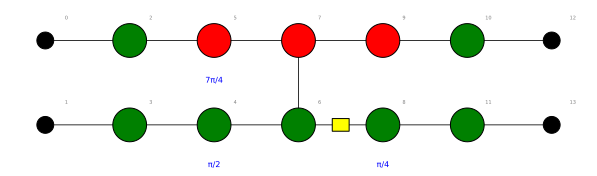

In [5]:
circ = zx.generate.cliffords(2,3,t_gates=True)

zx.draw(circ,labels=True,h_edge_draw='box')

In [6]:
t = tensorfy(circ)
t

array([[[[ 0.60355339+0.25j,  0.60355339-0.25j],
         [-0.10355339+0.25j,  0.10355339+0.25j]],

        [[ 0.00000000+0.j  ,  0.00000000+0.j  ],
         [ 0.00000000+0.j  ,  0.00000000+0.j  ]]],


       [[[ 0.00000000+0.j  ,  0.00000000+0.j  ],
         [ 0.00000000+0.j  ,  0.00000000+0.j  ]],

        [[ 0.60355339+0.25j,  0.60355339-0.25j],
         [-0.10355339+0.25j,  0.10355339+0.25j]]]])

spider_simp
1. 2. 1. 1. 
finished in 5 iterations
spider_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
lcomp_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
id_simp
2. 
finished in 2 iterations
spider_simp

finished in 1 iterations


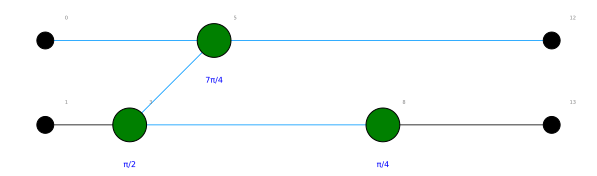

In [7]:
t = tensorfy(circ)
g = circ.copy()

zx.simplify.clifford_simp(g)
#g.set_phase(3,0)
t2 = tensorfy(g)
zx.draw(g,labels=True)
#np.allclose(t,t2)
#print(t,"\n\n", t2)

In [8]:
compare_tensors(t,t2)

True

In [102]:
t2

array([[[[ 0.70710678+0.j ,  0.50000000-0.5j],
         [ 0.00000000+0.j ,  0.00000000+0.j ]],

        [[ 0.00000000+0.j ,  0.00000000+0.j ],
         [ 0.00000000+0.j ,  0.00000000+0.j ]]],


       [[[ 0.00000000+0.j ,  0.00000000+0.j ],
         [ 0.00000000+0.j ,  0.00000000+0.j ]],

        [[ 0.70710678+0.j ,  0.50000000-0.5j],
         [ 0.00000000+0.j ,  0.00000000+0.j ]]]])

In [104]:
zx.draw(g.adjoint(),labels=True)
tadj = tensorfy(g.adjoint())
tadj
#np.tensordot(t2,tadj,axes=([2,3],[0,1]))
#id2 = Z_to_tensor(2,0)
#np.transpose(np.tensordot(id2,id2,axes=0),[0,2,1,3])

array([[[[ 0.70710678+0.j ,  0.50000000+0.5j],
         [ 0.00000000+0.j ,  0.00000000+0.j ]],

        [[ 0.00000000+0.j ,  0.00000000+0.j ],
         [ 0.00000000+0.j ,  0.00000000+0.j ]]],


       [[[ 0.00000000+0.j ,  0.00000000+0.j ],
         [ 0.00000000+0.j ,  0.00000000+0.j ]],

        [[ 0.70710678+0.j ,  0.50000000+0.5j],
         [ 0.00000000+0.j ,  0.00000000+0.j ]]]])

In [373]:
#tensor[1,1,0,1]
np.transpose(tensor, [3,2,0,1])
#np.transpose(tensor, [0,3,2,1])

array([[[[0.70710678+0.j, 0.        +0.j],
         [0.        +0.j, 0.70710678+0.j]],

        [[0.70710678+0.j, 0.        +0.j],
         [0.        +0.j, 0.70710678+0.j]]],


       [[[0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j]],

        [[0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j]]]])

In [95]:
id2 = Z_to_tensor(2,0)
z = Z_to_tensor(3,0)
print(z)
x = X_to_tensor(3,0)
print(x)
x2 = X_to_tensor(4,0)
a = np.tensordot(id2,z,axes=0)
cnot = np.tensordot(a,x,axes=([1,4],[2,0]))
cnot
#np.transpose(cnot,[0,1,3,2])
np.transpose(np.tensordot(z,x,(0,0)),[0,2,1,3])

[[[ 1.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j]]

 [[ 0.+0.j  0.+0.j]
  [ 0.+0.j  1.+0.j]]]
[[[ 0.70710678+0.j  0.00000000+0.j]
  [ 0.00000000+0.j  0.70710678+0.j]]

 [[ 0.00000000+0.j  0.70710678+0.j]
  [ 0.70710678+0.j  0.00000000+0.j]]]


array([[[[ 0.70710678+0.j,  0.00000000+0.j],
         [ 0.00000000+0.j,  0.00000000+0.j]],

        [[ 0.00000000+0.j,  0.70710678+0.j],
         [ 0.00000000+0.j,  0.00000000+0.j]]],


       [[[ 0.00000000+0.j,  0.00000000+0.j],
         [ 0.00000000+0.j,  0.70710678+0.j]],

        [[ 0.00000000+0.j,  0.00000000+0.j],
         [ 0.70710678+0.j,  0.00000000+0.j]]]])

In [79]:
i = 10
b = [int(j) for j in bin(i)[2:]]
b

[1, 0, 1, 0]

In [118]:
l = [1,2,3]
l.count(2)

1

In [363]:
id2 = [[1,0],[0,1]]
a = [[[1,0],[0,0]],[[0,0],[0,1]]]
b = [[[1,0],[0,1]],[[0,1],[1,0]]]
print(np.einsum("klm,iln->kimn",a,b))
#print(np.tensordot(a,b, axes=(0,0)))
c = np.tensordot(id2, a, axes=0)
cnot = np.tensordot(c,b,axes=([1,3],[1,0]))
#print(cnot)
cnot2 = np.tensordot(id2,np.tensordot(a,b,axes=(1,0)),axes=(1,0))
#print(cnot2)
np.einsum("ij,klm,jln->ikmn",id2,a,b)

[[[[1 0]
   [0 0]]

  [[0 1]
   [0 0]]]


 [[[0 0]
   [0 1]]

  [[0 0]
   [1 0]]]]


array([[[[1, 0],
         [0, 0]],

        [[0, 0],
         [0, 1]]],


       [[[0, 1],
         [0, 0]],

        [[0, 0],
         [1, 0]]]])